# Linear Regression
<div class="alert alert-block alert-info">
<b>Content:</b> In this notebook we run linear regression for a couple of experiments
    
* analysis of data
* prediction of data using the plain linear regression
* prediction of data using modified versions
</div>


In [21]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.base import BaseEstimator
from sklearn.preprocessing import PolynomialFeatures

## The Dataset

The following uses a __hypothetical__ demo dataset provided by the company glassdoor. The dataset is suitable for analyzing gender gaps in populations, e.g. the employees of a company.

In [22]:
raw_data=pd.read_csv("glassdoor.csv")
print(raw_data.shape)

(1000, 9)


In [23]:
raw_data.head()

,jobTitle,gender,age,perfEval,edu,dept,seniority,basePay,bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319


In [24]:
target=raw_data.basePay+raw_data.bonus
raw_features =raw_data.drop(["basePay", "bonus"], axis=1)
features=pd.get_dummies(raw_features, drop_first=True)

In [25]:
features.head()

,age,perfEval,seniority,jobTitle_Driver,jobTitle_Financial Analyst,jobTitle_Graphic Designer,jobTitle_IT,jobTitle_Manager,jobTitle_Marketing Associate,jobTitle_Sales Associate,jobTitle_Software Engineer,jobTitle_Warehouse Associate,gender_Male,edu_High School,edu_Masters,edu_PhD,dept_Engineering,dept_Management,dept_Operations,dept_Sales
0,18,5,2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,21,5,5,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False
2,19,4,5,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
3,20,5,4,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,True
4,26,5,5,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,False,False


## Descriptive Data Analysis

### Checking for Correlation

In [26]:
print("age:", pearsonr(target, features.age)) # returns correlation and p-value (smaller means more indication of a non-coincidental result)
print("perfEval:", pearsonr(target, features.perfEval))
print("seniority:", pearsonr(target, features.seniority))
print("gender_Male:", pearsonr(target, features.gender_Male))

age: PearsonRResult(statistic=0.533714613357254, pvalue=1.0414950106400532e-74)
perfEval: PearsonRResult(statistic=0.014154722745268494, pvalue=0.6548214899148318)
seniority: PearsonRResult(statistic=0.5303068180320669, pvalue=1.3074576224991663e-73)
gender_Male: PearsonRResult(statistic=0.1687164250087755, pvalue=8.000016978237541e-08)


In [27]:
def pearson(i):
    a=pearsonr(target, features[i])
    return [a.statistic, a.pvalue]
    
d=pd.DataFrame(columns=["feature", "pearson", "p-value"], 
               data=[[i]+pearson(i) for i in features.columns])
d.round(2).sort_values("pearson")

,feature,pearson,p-value
8,jobTitle_Marketing Associate,-0.26,0.00
13,edu_High School,-0.14,0.00
18,dept_Operations,-0.09,0.00
3,jobTitle_Driver,-0.06,0.04
6,jobTitle_IT,-0.05,0.11
11,jobTitle_Warehouse Associate,-0.05,0.10
5,jobTitle_Graphic Designer,-0.04,0.18
9,jobTitle_Sales Associate,-0.02,0.61
1,perfEval,0.01,0.65
4,jobTitle_Financial Analyst,0.01,0.84


* We observe significant high correlation between
    * target and age and
    * target and seniority.

There is also a (less strong yet significant) correlation between target and gender!

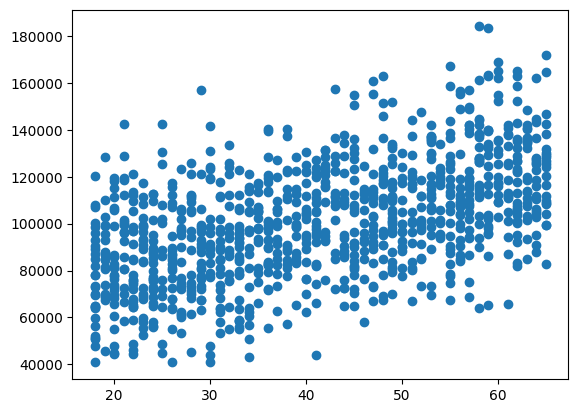

In [28]:
plt.scatter(raw_data.age, target)

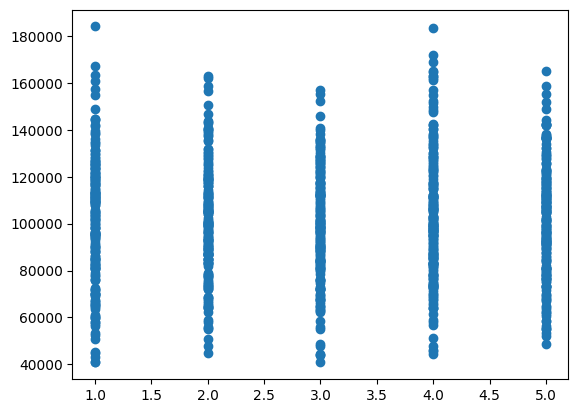

In [29]:
plt.scatter(raw_data.perfEval, target)

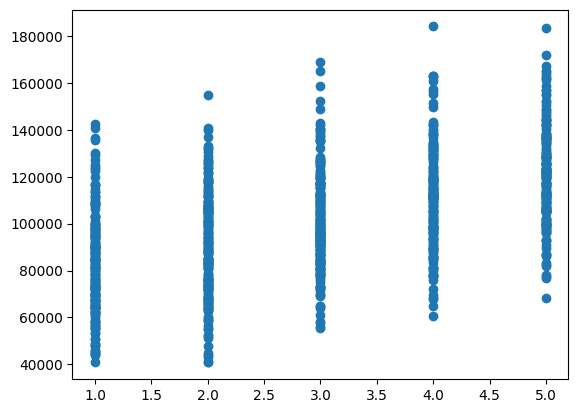

In [30]:
plt.scatter(raw_data.seniority, target)

Plots are nice, but often deceptive. Even though the two above plots look similar, the correlation they are supposed to show is absolutely not similar!

### Analysis By Linear Regression on the Full Dataset
Linear Regression as an Exploratory Tool

In [31]:
reg_full= LinearRegression()
reg_full.fit(np.array(features), target)

LinearRegression()

In [32]:
reg_full_r2=r2_score(target, reg_full.predict(np.array(features)))
reg_full_r2

0.8413655415342493

The linear regression model explains some part (64%) of the variance. There is also some unexplained variance in the data.

In [33]:
w=reg_full.coef_
w

array([   948.94638422,   1156.87968348,   9903.71031465,  -3928.98117931,
         3417.70899905,  -2457.69921434,  -2149.70220062,  31601.19665523,
       -17013.78010451,    263.44561288,  13386.52327525,   -564.01711738,
          392.32441404,  -1435.16933114,   4717.99711164,   6026.28666064,
         3267.93583785,   2957.82896035,   -481.49679312,   6193.49622777])

In [34]:
for i in range(0, len(features.columns)): 
    print(features.columns[i], w[i])

age 948.9463842216244
perfEval 1156.87968347776
seniority 9903.710314646132
jobTitle_Driver -3928.9811793126373
jobTitle_Financial Analyst 3417.708999051176
jobTitle_Graphic Designer -2457.6992143378748
jobTitle_IT -2149.702200620667
jobTitle_Manager 31601.196655226755
jobTitle_Marketing Associate -17013.78010451401
jobTitle_Sales Associate 263.4456128812517
jobTitle_Software Engineer 13386.523275253314
jobTitle_Warehouse Associate -564.0171173788516
gender_Male 392.32441404310225
edu_High School -1435.1693311441286
edu_Masters 4717.997111637642
edu_PhD 6026.286660642827
dept_Engineering 3267.935837853406
dept_Management 2957.828960348783
dept_Operations -481.4967931227314
dept_Sales 6193.496227765078


Interpretation Examples of the model: Ceteris Paribus
* aging a year correlates with a total pay increase of 693 dollars
* with high school as highest education (instead of college) decreases total pay by -2012 dollars, wheras a PhD increases the total py by 6463 dollars
* departments Engineering and Management lead to higher sallaries than Operations and Sales
* males receive 6352 dollars more than females

These numbers assume that the learned model fully describes the data and they are not to be misunderstood as mathematical properties!

The population parameters are NO measure for correlation (compare e.g. age and perfEval!)

The results say nothing about causation. Thus it would not be reasonable to assume that generally simply getting older increases your pay.

# Plotting Residuals

FileNotFoundError: [Errno 2] No such file or directory: 'results/target-residuals.pdf'

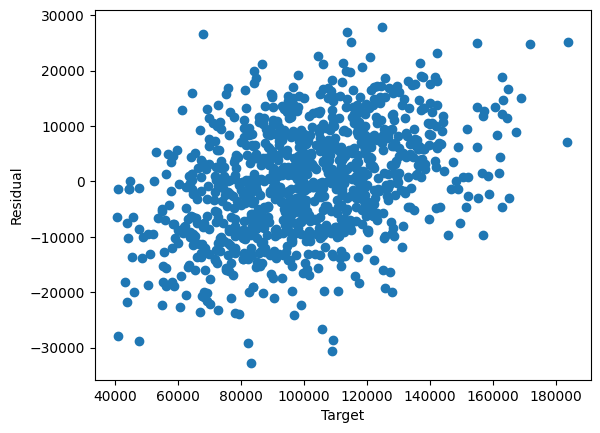

In [35]:
plt.scatter(target, target-reg_full.predict(np.array(features)))
plt.xlabel("Target")
plt.ylabel("Residual")
plt.savefig('results/target-residuals.pdf')

FileNotFoundError: [Errno 2] No such file or directory: 'results/residuals.pdf'

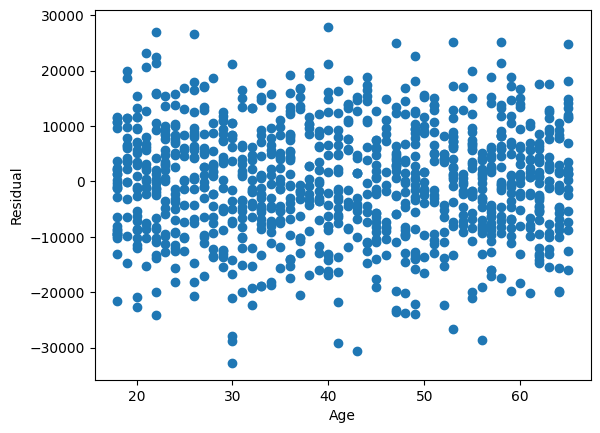

In [36]:
plt.scatter(features.age, target-reg_full.predict(np.array(features)))
plt.xlabel("Age")
plt.ylabel("Residual")
plt.savefig('results/residuals.pdf')

* The residuals plot reveals high residuals.
* This suggests that not enough information is given in the features to fully explain the target.
* There is no obvious dependence of residuals on age.

### Using Linear Regression to Investigate Specific Variables

In [37]:
reg_age = LinearRegression()
reg_age.fit(np.expand_dims(np.array(raw_data.age), axis=1), target)
w=reg_age.coef_
b=reg_age.intercept_
age_space=np.arange(0,70,1)
y=reg_age.predict(age_space.reshape(-1,1))

In [38]:
r2_score(target, reg_age.predict(np.array(raw_data[["age"]])))

0.2848512885110833

There is (of cause) much more unexplained variance.

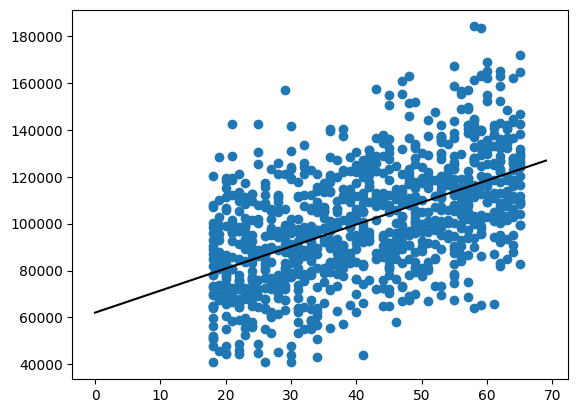

In [39]:
plt.scatter(raw_data.age, target)
plt.plot(age_space, y, c='black')

### Investigate Two Variables
Equal-Slopes method (assumption: both features are independent)

In [40]:
reg_age_sen = LinearRegression()
reg_age_sen.fit(np.array(raw_data[["age", "seniority"]]), target)

LinearRegression()

In [41]:
reg_age_sen.coef_

array([ 959.67476428, 9773.62023346])

In [42]:
r2_score(target, reg_age_sen.predict(np.array(raw_data[["age", "seniority"]])))

0.5784635185629357

In [43]:
age_space=np.arange(0,70,1)
seniority_space=np.arange(1,6,1)

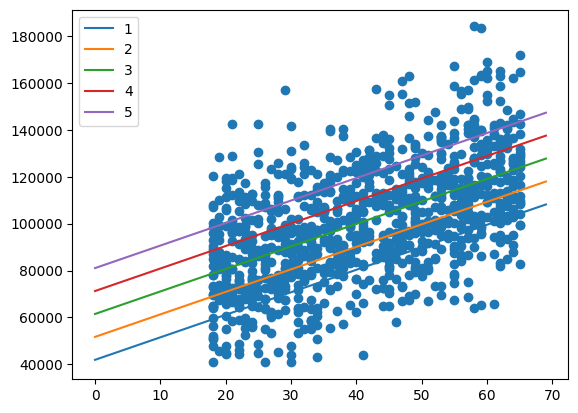

In [44]:
plt.scatter(raw_data.age, target)
for s in range(0,len(seniority_space), 1):
    grid=np.stack((age_space, seniority_space[s]*np.ones_like(age_space)), axis=1)
    y=reg_age_sen.predict(grid)
    plt.plot(age_space, y, label=seniority_space[s])
plt.legend()

higher age and higher seniority correlate positively with higher total pay
Linear model -> parallel slopes. Alterantive: Compute own models for each seniority level (treat different seniorities as different populations)

# Evaluation of Machine Learning Models

In [45]:
inner_cv = KFold(n_splits=10, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)

def print_eval(result):
    #print(result, 3)
    print("RMSE: {:,.2f}".format(np.round(np.sqrt(-1*res.mean()), 3)))
    print(" MSE: {:,.2f}".format(-1*np.round(res.mean(), 3)), "±", "{:,.2f}".format(np.round(res.std(), 3)))

## Linear Regression

In [46]:
res=cross_val_score(LinearRegression(), np.array(features), target, cv=outer_cv, n_jobs=5, scoring='neg_mean_squared_error')
print_eval(res)

RMSE: 10,224.75
 MSE: 104,545,486.68 ± 15,964,631.43


## Polynomial Regression

In [47]:
poly=PolynomialFeatures(degree=4)
X_poly=poly.fit_transform(np.array(features))
print(features.shape)
print(X_poly.shape)
reg=LinearRegression()
reg.fit(X_poly,target)

(1000, 20)
(1000, 10626)


LinearRegression()

In [48]:
r2_score(target, reg.predict(X_poly))

0.9997285227386018

In [49]:
reg_full_r2 # for comparison the respective value of the linear fit

0.8413655415342493

The significantly(!) more complex model explains the variance better. But, does it lead to better predictive performance or rather to overfitting? -> Proper ML Evaluation

In [50]:
class PolynomialRegression(BaseEstimator):
    def __init__(self, degree=1):
        self.degree = degree
    
    def fit(self, X, y):
        self.model = LinearRegression(fit_intercept=False) # polynomial features create a feature with degree 0: 1
        self.poly_feature=PolynomialFeatures(degree=self.degree)
        X_poly=self.poly_feature.fit_transform(X)
        self.model.fit(X_poly, y)
    
    def predict(self, X):
        return self.model.predict(self.poly_feature.transform(X))
    
    def coef_(self):
        return self.model.coef_


In [63]:
poly_reg=PolynomialRegression()

poly_reg_grid={
    'degree':[1,2,3,4]
}
poly_reg_grid_cv = GridSearchCV(
    estimator=poly_reg, param_grid=poly_reg_grid, cv=inner_cv, n_jobs=5, scoring='neg_mean_squared_error')
res=cross_val_score(poly_reg_grid_cv, np.array(features), target, cv=outer_cv, n_jobs=5, scoring='neg_mean_squared_error')

print_eval(res)

RMSE: 10,224.75
 MSE: 104,545,486.68 ± 15,964,631.43


In [64]:
poly_reg_grid_cv.fit(features,target)
poly_reg_grid_cv.best_params_

{'degree': 1}

* Interpretation of polynomial regression is much more difficult.
* However, additional non-linear variable allow a better fit to the data (more explained variance)
* HOWEVER: This did not translate into a boost of predictive performance!

<div class="alert alert-block alert-info">
<b>Take Aways:</b> 

* Running Linear Regression.
* Linear Regression Coefficients can be interpreted (ceteris paribus)
* The interpretation is however limited.
* The residuals can and should be investigated.
* Similar to the kernel trick of SVMs, we can turn linear regression into non-linear regression, here polynomial regression.
</div>

Remarks on the observed gender pay gap evidence:
* Data ignores non-binary gender.
* Data taken from https://research.glassdoor.com/site-us/wp-content/uploads/sites/2/2019/03/GD_Report_AnalyzingGenderPayGap_v2-2.pdf

* It represents __hypothetical__ data, thus __no real evidence__.

__If__ the data __was__ real, our analysis would have revealed, that a gender pay gap does exist -- within the considered data. (This is a topic with potentially vastly different results in different countries and different industries).

* Multiple factors might lead directly or indirectly to a pay gap
     * directly: individuals of a group get payed less, despite the same education/job-title/seniority/... 
     * indirectly:
         * a group works more often in less-well payed jobs
         * a group is underrepresented in the higher educational
         * a group does not reach the same seniority levels as others (usually seniority is correlated with long-term full-time employment)

To investigate such factors, one can gather first evidence:

In [53]:
raw_data

,jobTitle,gender,age,perfEval,edu,dept,seniority,basePay,bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319
...,...,...,...,...,...,...,...,...,...
995,Marketing Associate,Female,61,1,High School,Administration,1,62644,3270
996,Data Scientist,Male,57,1,Masters,Sales,2,108977,3567
997,Financial Analyst,Male,48,1,High School,Operations,1,92347,2724
998,Financial Analyst,Male,65,2,High School,Administration,1,97376,2225


In [54]:
raw_data["total"] = raw_data.basePay+raw_data.bonus

In [55]:
gender_avg=raw_data[['gender', 'total']].groupby('gender').aggregate(['min', 'max', 'mean'])
gender_avg

total                       
          min     max           mean
gender                              
Female  40828  168968   96416.831197
Male    41030  184010  104918.678571

In [56]:
def gap(a,b):
    return (b-a)/b*100

In [57]:
gap(gender_avg[('total', 'mean')]['Female'], gender_avg[('total', 'mean')]['Male'])

8.103273402418342

In [58]:
mean_per_jobtitle=raw_data[['jobTitle', 'total']].groupby(['jobTitle']).aggregate(mean=('total', 'mean'))
mean_per_jobtitle

,mean
jobTitle,
Data Scientist,98918.411215
Driver,95778.890110
Financial Analyst,101403.626168
Graphic Designer,97674.530612
IT,97030.395833
Manager,131392.177778
Marketing Associate,82802.127119
Sales Associate,99670.787234
Software Engineer,112161.412844


In [59]:
def get_gender_table_for_criterion(raw_data, criterion):
    mean_per_criterion=raw_data[[criterion, 'total']].groupby([criterion]).aggregate(mean=('total', 'mean'))

    a=raw_data[['gender', criterion, 'total']].groupby(['gender', criterion]).aggregate(mean=('total', 'mean'), count=('total', 'count'))
    a=a.reset_index()
    b=a.pivot(index=criterion, columns='gender')
    b.columns = ['_'.join(col) for col in b.columns]
    
    b['gap']=b.apply(lambda x: gap(a = x['mean_Female'], b = x['mean_Male']), axis=1)
    
    b = pd.concat([b,mean_per_criterion], axis=1) 
    b=b.sort_values('mean')
    return b

In [60]:
get_gender_table_for_criterion(raw_data, 'jobTitle').round(2)

,mean_Female,mean_Male,count_Female,count_Male,gap,mean
jobTitle,,,,,,
Marketing Associate,82251.15,88161.64,107,11,6.70,82802.13
Driver,93197.35,98417.80,46,45,5.30,95778.89
Warehouse Associate,100083.93,93363.61,46,44,-7.20,96798.44
IT,96837.94,97239.59,50,46,0.41,97030.40
Graphic Designer,98810.42,96584.08,48,50,-2.31,97674.53
Data Scientist,102452.26,95450.00,53,54,-7.34,98918.41
Sales Associate,98220.53,100893.55,43,51,2.65,99670.79
Financial Analyst,101743.65,101116.36,49,58,-0.62,101403.63
Software Engineer,101147.38,113033.81,8,101,10.52,112161.41


In [61]:
get_gender_table_for_criterion(raw_data, 'seniority')

,mean_Female,mean_Male,count_Female,count_Male,gap,mean
seniority,,,,,,
1,75512.349398,88323.232143,83,112,14.504545,82870.394872
2,85675.666667,95555.504673,102,107,10.339371,90733.765550
3,97735.141509,104204.530973,106,113,6.208357,101073.228311
4,106045.937500,114731.567308,80,104,7.570392,110955.206522
5,116216.845361,124926.052083,97,96,6.971490,120548.886010


In [62]:
get_gender_table_for_criterion(raw_data, 'edu')

,mean_Female,mean_Male,count_Female,count_Male,gap,mean
edu,,,,,,
High School,92194.818182,97527.909774,132,133,5.468272,94871.426415
College,92917.219512,104672.228814,123,118,11.230304,98672.784232
Masters,99042.971963,107659.812081,107,149,8.003767,104058.242188
PhD,103084.386792,109491.590909,106,132,5.851777,106637.962185


__Technical Remarks___
All these investigations could be conducted by grouping by more than just one entity (e.g. combinations of edu/seniority/jobTitle/dept.
* Generally very many subgroups to investigate separately, no overall impression.
* Often small groups (statistical significance problematic).
* Other ideas include "corrections" - adjustments to account for the influcences of other groups.
* Uneven Distribution over different fields often leads to counter-intuitive results. Look up "Simpson's Paradox".

__General Remarks__
* No matter which influences create the pay gap (direkt or indirect influences), it is still a pay gap. The analysis of the factors does not change that, however, depending on the factors, different levers are needed to fix it.
* While this data is hypothetical, the gender pay gap is a well-known statistically proven phenomenon. E.g. a comparison on European countries here: https://www.destatis.de/Europa/EN/Topic/Population-Labour-Social-Issues/Labour-market/gender_pay_gap.html


<div class="alert alert-block alert-success">
<b>Play with:</b> 
    
* change the target attribute (e.g. square the values, use the logarithm)
* use linear regression on that and compare to polynomial regression
</div>
